In [48]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from keras.preprocessing.image import ImageDataGenerator
from itertools import chain
import random
random_state = 42
import sklearn.model_selection as skl
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import binarize

## Do some early processing of your metadata for easier model training:

In [2]:
## code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
67008,00016568_009.png,Edema|Infiltration|Mass|Pneumonia,9,16568,38,F,AP,2500,2048,0.168,0.168,NaN,/data/images_008/images/00016568_009.png
75968,00018629_000.png,Atelectasis|Effusion,0,18629,78,M,PA,2878,2991,0.143,0.143,NaN,/data/images_009/images/00018629_000.png
49933,00012641_001.png,Nodule,1,12641,47,M,PA,2992,2991,0.143,0.143,NaN,/data/images_006/images/00012641_001.png


In [3]:
## get a list of all labes in the datset
All_Labels = np.unique(list(chain(*all_xray_df["Finding Labels"].map(lambda x: x.split("|")).tolist())))
All_Labels = [x for x in All_Labels if len(x)>0]
## convert all diseases in the dataset to binary flag (1 for positive, 0 for negative)
for c_labels in All_Labels:
    if len(c_labels)>1:
        all_xray_df[c_labels] = all_xray_df["Finding Labels"].map(lambda finding: 1.0 if c_labels in finding else 0)
all_xray_df.head()  

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = all_xray_df.apply(lambda df: '1' if df['Pneumonia']== 1.0 else '0', axis=1)
all_xray_df.sample(5, random_state = random_state)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
89645,00022260_003.png,No Finding,3,22260,54,F,PA,2542,2434,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
47446,00012048_007.png,Infiltration|Mass|Nodule,7,12048,65,M,AP,2500,2048,0.168,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0
57963,00014352_005.png,No Finding,5,14352,6,M,PA,2992,2033,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
22863,00006040_001.png,No Finding,1,6040,18,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
43431,00011202_002.png,No Finding,2,11202,19,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


## Create training and testing data:

In [5]:
def create_splits(vargs):
    

    train_data, val_data = skl.train_test_split(vargs, 
                                   test_size = 0.2, 
                                   stratify = vargs['pneumonia_class'],
                                             random_state = random_state)
    
    ## we want our model to be trained on a set that has equal proportions of pneumonia and non_pneumonia
    p_inds  = train_data[train_data['pneumonia_class']=='1'].index.tolist()
    np_inds = train_data[train_data['pneumonia_class']=='0'].index.tolist()
    
    ##randomly set of pneumonia images as the number of true non_pneumonia cases
    random.seed(random_state)
    np_sample = random.sample(np_inds,len(p_inds))
    
    ##remove out the rest of the non-pneumonia cases
    train_data = train_data.loc[p_inds + np_sample]
    
    ## Now our training dataset is balanced 50-50%
    ## we want to make the balance in our validation 20-80% 
    ## given that the prevalence of pneumonia  in this clinical situation is about 20%:
    bal_p_inds  = val_data[val_data['pneumonia_class']=='1'].index.tolist()
    bal_np_inds = val_data[val_data['pneumonia_class']=='0'].index.tolist()
    
    bal_np_sample = random.sample(bal_np_inds,4*len(bal_p_inds))
    val_data = val_data.loc[bal_p_inds + bal_np_sample]
    
    return train_data, val_data

In [6]:
## recall the function to split the dataset
train_data, val_data = create_splits(all_xray_df)
# Check the fraction of positive cases in the training and validation setdataset
print (" Training dataset is balanced" ,train_data[train_data['pneumonia_class'] == '1']['pneumonia_class'].count()/len(train_data))
print (" The prevalence of pneumonia in validation dataset is balanced" ,val_data[val_data['pneumonia_class'] == '1']['pneumonia_class'].count()/len(val_data))

 Training dataset is balanced 0.5
 The prevalence of pneumonia in validation dataset is balanced 0.2


# Now we can begin our model-building & training

In [7]:
## we first choose an image size to resize images to during augmentation,
## which comes in handy later when you using a pre-trained CNN that has a specified size input layer
IMG_SIZE = (224, 224)

In [8]:
def my_image_augmentation(vargs):
    


     ## implement a package like Keras' ImageDataGenerator  with some of the built-in augmentationsto train
    my_train_idg = ImageDataGenerator(rescale=1.0 / 255, ## rescale instea of normalizasion 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    
    ## implement a package like Keras' ImageDataGenerator  with some of the built-in augmentationsto validation 
    ## Note that the validation data should not be augmented! We only want to do some basic intensity rescaling here
    my_val_idg = ImageDataGenerator(rescale=1.0 / 255)
    
    return my_train_idg, my_val_idg

In [9]:
my_train_idg, my_val_idg = my_image_augmentation(255)

In [10]:
def make_train_gen(vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_data, 
                                          directory= None, 
                                         x_col = "path",
                                         y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size =IMG_SIZE , 
                                          batch_size = 32,
                                          seed= random_state
                                          )


    return train_gen


def make_val_gen(vargs):
    
    
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe=val_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = len(val_data), 
                                         seed = random_state)     
    return val_gen

In [11]:
train_gen = make_train_gen(train_data)
val_gen = make_val_gen(val_data)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [12]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

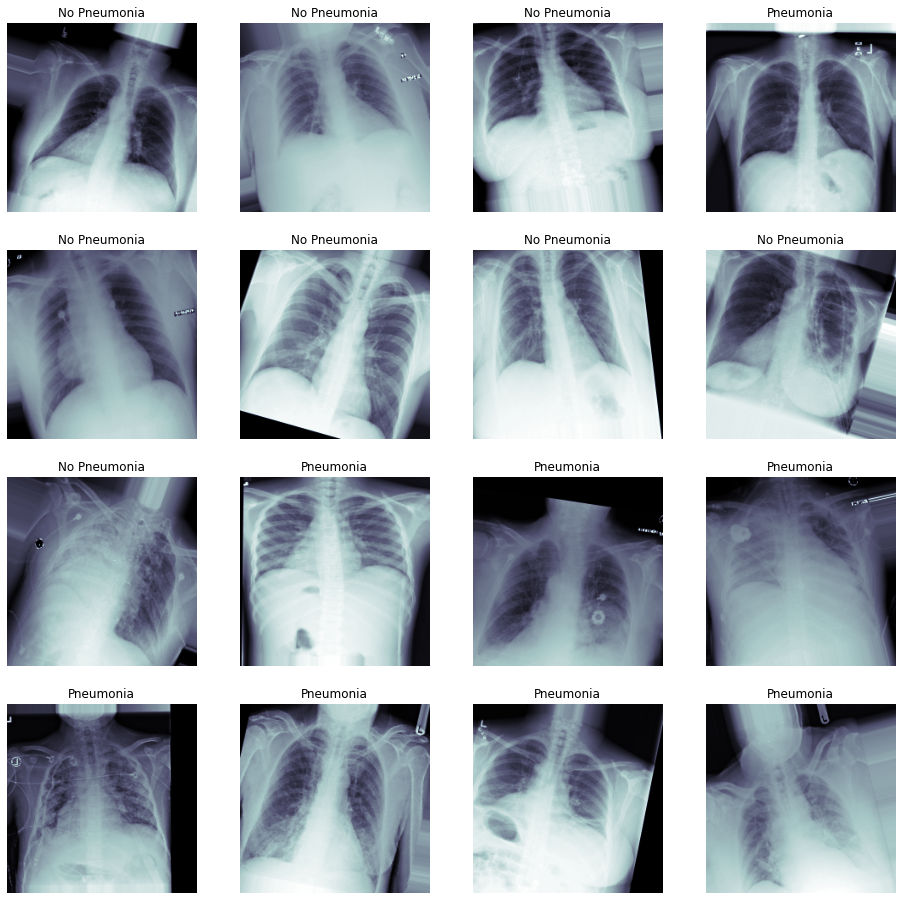

In [13]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build the model: 


In [14]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    
    ## Since the last convolutional layer is called block5_pool, 
    ## this layer is refereed to transfer layer by using keras to reference it.
    ## Since this layer consist all of the convolutional layers from the VGG16 model,
    ## it's output will be rerouted to a new neural network which will do the classification.
    transfer_layer = model.get_layer("block5_pool") 
    
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)

    
    return vgg_model

In [15]:
vgg_model = load_pretrained_model()

553467904/553467096 [==============================] - 6s 0us/step


In [16]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [36]:
def build_my_model(model, last_frrezed_layer = -1, conv_layer = None, fully_connected_layer=[]):
    
    if conv_layer == None:
        for layer in model.layers[0:last_frrezed_layer]:
            layer.trainable = False
            
    else:
        for i , layer in enumerate(model.layers):
            if i != conv_layer:
                layer.trainable = False
                
    model = Sequential()
    # add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    model.add(vgg_model)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    model.add(Flatten())
    # also make sure you set your optimizer, loss function, and metrics to monitor
    if len(fully_connected_layer) > 0:
        for index, num in enumerate(fully_connected_layer):
            model.add(Dropout(0.5))
            model.add(Dense(num, activation='relu'))
              
    model.add(Dense(1, activation='sigmoid'))
    
    ## Set our optimizer, loss function, and learning rate
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    
    return model


In [19]:
## Run for 5 epochs to see if any learning occurs:
my_model = build_my_model(vgg_model)
my_model.fit_generator(train_gen, 
                       validation_data = (valX, valY), 
                       epochs = 5)

Epoch 1/5
72/72 [==============================] - 77s 1s/step - loss: 0.6932 - binary_accuracy: 0.5515 - val_loss: 0.8139 - val_binary_accuracy: 0.3350
Epoch 2/5
72/72 [==============================] - 61s 846ms/step - loss: 0.6729 - binary_accuracy: 0.5900 - val_loss: 0.7329 - val_binary_accuracy: 0.5098
Epoch 3/5
72/72 [==============================] - 62s 868ms/step - loss: 0.6609 - binary_accuracy: 0.6135 - val_loss: 0.6841 - val_binary_accuracy: 0.5643
Epoch 4/5
72/72 [==============================] - 61s 851ms/step - loss: 0.6559 - binary_accuracy: 0.6166 - val_loss: 0.6470 - val_binary_accuracy: 0.6203
Epoch 5/5
72/72 [==============================] - 62s 857ms/step - loss: 0.6569 - binary_accuracy: 0.6188 - val_loss: 0.6221 - val_binary_accuracy: 0.6497


In [20]:

## This will save the 'best' version of your model by comparing it to previous epochs of training

## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting



weight_path="{}my_model.best.hdf5".format('pneumonia_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [21]:
## train the model
history = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                          epochs = 10 , 
                          callbacks = callbacks_list)

Epoch 1/10
72/72 [==============================] - 70s 969ms/step - loss: 0.6479 - binary_accuracy: 0.6236 - val_loss: 0.7196 - val_binary_accuracy: 0.5224

Epoch 00001: val_loss improved from inf to 0.71961, saving model to pneumonia_classmy_model.best.hdf5
Epoch 2/10
72/72 [==============================] - 62s 857ms/step - loss: 0.6451 - binary_accuracy: 0.6336 - val_loss: 0.6430 - val_binary_accuracy: 0.6273

Epoch 00002: val_loss improved from 0.71961 to 0.64305, saving model to pneumonia_classmy_model.best.hdf5
Epoch 3/10
72/72 [==============================] - 61s 847ms/step - loss: 0.6444 - binary_accuracy: 0.6288 - val_loss: 0.6115 - val_binary_accuracy: 0.6594

Epoch 00003: val_loss improved from 0.64305 to 0.61153, saving model to pneumonia_classmy_model.best.hdf5
Epoch 4/10
72/72 [==============================] - 60s 836ms/step - loss: 0.6426 - binary_accuracy: 0.6319 - val_loss: 0.7511 - val_binary_accuracy: 0.4930

Epoch 00004: val_loss did not improve from 0.61153
Epo

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [22]:
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

1430/1430 [==============================] - 12s 9ms/step


In [23]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    fig, ax = plt.subplots(1,1, figsize = (7, 7))    
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    ax.plot(fpr, tpr, label = 'AUC = %0.3f'  % (auc(fpr, tpr)))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate') 
    ax.legend(loc = 'best')
    return

## what other performance statistics do you want to include here besides AUC? 
def f1_plot(t_y, p_y):    
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    f1s = [f1_score(t_y, binarize(p_y, ind)) for ind in thresholds]
    fig, ax = plt.subplots(1,1, figsize = (7, 7))
    ax.plot(thresholds, f1s, label = 'F1 Score')
    ax.legend()
    ax.set_xlabel('Threshold')
    ax.set_ylabel('F1 Score')
    ax.set_title('F1_score vs Threshold')

def prec_recall_plot(t_y, p_y):
# Todo
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    fig, ax = plt.subplots(1,1, figsize = (7, 7))
    ax.plot(recall, precision)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    return
    
#Also consider plotting the history of your model training:
def plot_history(history):        
    # Todo
    x_values = np.arange(0, len(history.history["loss"]))
    metrics = ["loss", "val_loss", "binary_accuracy", "val_binary_accuracy"]
    labels = ["train_loss", "val_loss", "train_acc", "val_acc"]
    markers = ['k-', 'r-', 'b-', 'g-']
    plt.figure(figsize=(7,7))
    for ind, metric in enumerate(metrics):
        plt.plot(x_values, history.history[metric], markers[ind] , label=labels[ind])
    plt.title("Training & Validation Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="best")    
    return

# function to calculate the F1 score
def calc_f1(precision,recall):
    return 2*(precision*recall)/(precision+recall)

# function to obtain threshold at maximum f1_score => best threshold
def best_threshold(precision, recall):
# def ...
# Todo
    
    
    """
    This function finds the threshold at maximum f1_score computed 
    from input precision and recall. It prints the threshold and the 
    corresponding precision and recall.   
    
    """   
    f1_score = calc_f1(precision, recall)
    idx_max_f1_score = np.nanargmax(f1_score) # find the index at maximum f1_score
    best_threshold = thresholds[idx_max_f1_score]
    # print corresponding threshold, precision and recall
    print('Threshold that maximized f1_score is: %.3f'%best_threshold)
    print('Corresponding Precision is: %.3f'%precision[idx_max_f1_score])
    print('Recall is: %.2f'%recall[idx_max_f1_score])
    
    return best_threshold

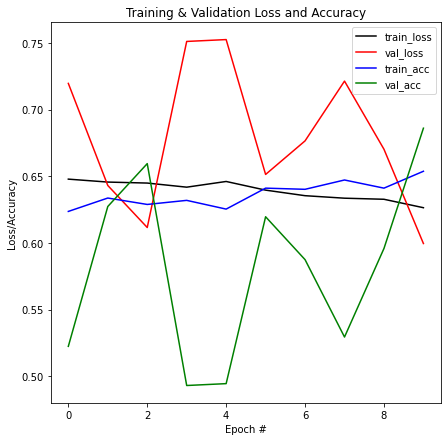

In [24]:
## plot figures
plot_history(history)
# Todo

The model looks unstable and stopped learning after epoch7 since the val loss increased.

## Round_1

In [37]:
### last layer
### dropout
### 2 connected layres
vgg_model_1 = load_pretrained_model()
my_model_1 = my_model = build_my_model(vgg_model_1,
                                       last_frrezed_layer = -1,
                                       conv_layer = None, 
                                       fully_connected_layer=[1024,512]
                                      )
weight_path_1="{}my_model_1.best.hdf5".format('pneumonia_class')

checkpoint_1 = ModelCheckpoint(weight_path_1, 
                             monitor= 'val_loss', 
                             verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early_1 = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list_1 = [checkpoint_1, early_1]

history_1 = my_model_1.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 12, 
                           callbacks = callbacks_list_1)

Epoch 1/12
72/72 [==============================] - 70s 973ms/step - loss: 0.7700 - binary_accuracy: 0.5410 - val_loss: 0.7200 - val_binary_accuracy: 0.4923

Epoch 00001: val_loss improved from inf to 0.72004, saving model to pneumonia_classmy_model_1.best.hdf5
Epoch 2/12
72/72 [==============================] - 63s 869ms/step - loss: 0.7358 - binary_accuracy: 0.5454 - val_loss: 0.5730 - val_binary_accuracy: 0.7657

Epoch 00002: val_loss improved from 0.72004 to 0.57304, saving model to pneumonia_classmy_model_1.best.hdf5
Epoch 3/12
72/72 [==============================] - 61s 852ms/step - loss: 0.7205 - binary_accuracy: 0.5590 - val_loss: 0.6814 - val_binary_accuracy: 0.5678

Epoch 00003: val_loss did not improve from 0.57304
Epoch 4/12
72/72 [==============================] - 61s 848ms/step - loss: 0.7076 - binary_accuracy: 0.5664 - val_loss: 0.5652 - val_binary_accuracy: 0.7608

Epoch 00004: val_loss improved from 0.57304 to 0.56518, saving model to pneumonia_classmy_model_1.best.hd

1430/1430 [==============================] - 12s 9ms/step


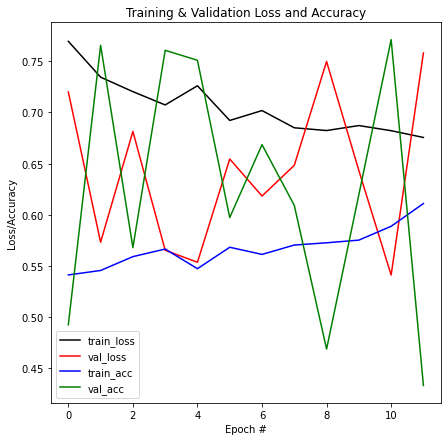

In [39]:
my_model_1.load_weights(weight_path_1)
pred_Y_1 = my_model_1.predict(valX, verbose = True)
plot_history(history_1)

The model performs better but still unstable

## Round_2

In [40]:
### last layer
### dropout
### 3 connected layres
vgg_model_2 = load_pretrained_model()
my_model_2 = my_model = build_my_model(vgg_model_2,
                                       last_frrezed_layer = -1,
                                       conv_layer = None, 
                                       fully_connected_layer=[1024,512,256]
                                      )
weight_path_2="{}my_model_2.best.hdf5".format('pneumonia_class')

checkpoint_2 = ModelCheckpoint(weight_path_2, 
                             monitor= 'val_loss', 
                             verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early_2 = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list_2 = [checkpoint_2, early_2]

history_2 = my_model_2.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 12, 
                           callbacks = callbacks_list_2)

Epoch 1/12
72/72 [==============================] - 69s 952ms/step - loss: 0.8236 - binary_accuracy: 0.5092 - val_loss: 0.6111 - val_binary_accuracy: 0.7860

Epoch 00001: val_loss improved from inf to 0.61106, saving model to pneumonia_classmy_model_2.best.hdf5
Epoch 2/12
72/72 [==============================] - 60s 839ms/step - loss: 0.7515 - binary_accuracy: 0.5170 - val_loss: 0.5796 - val_binary_accuracy: 0.8000

Epoch 00002: val_loss improved from 0.61106 to 0.57957, saving model to pneumonia_classmy_model_2.best.hdf5
Epoch 3/12
72/72 [==============================] - 61s 848ms/step - loss: 0.7402 - binary_accuracy: 0.5079 - val_loss: 0.5683 - val_binary_accuracy: 0.7972

Epoch 00003: val_loss improved from 0.57957 to 0.56826, saving model to pneumonia_classmy_model_2.best.hdf5
Epoch 4/12
72/72 [==============================] - 60s 838ms/step - loss: 0.7229 - binary_accuracy: 0.5332 - val_loss: 0.6859 - val_binary_accuracy: 0.5552

Epoch 00004: val_loss did not improve from 0.568

1430/1430 [==============================] - 13s 9ms/step


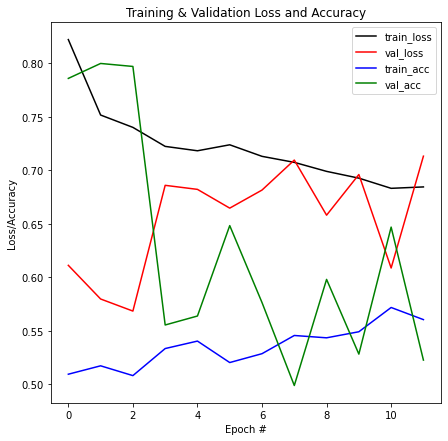

In [41]:
my_model_2.load_weights(weight_path_2)
pred_Y_2 = my_model_2.predict(valX, verbose = True)
plot_history(history_2)

The model looks more stable. needs more improvement

## Round_3

In [42]:
### last layer
### dropout
### 4 connected layres
vgg_model_3 = load_pretrained_model()
my_model_3 = my_model = build_my_model(vgg_model_3,
                                       last_frrezed_layer = -1,
                                       conv_layer = None, 
                                       fully_connected_layer=[1024,512,256,128]
                                      )
weight_path_3="{}my_model_3.best.hdf5".format('pneumonia_class')

checkpoint_3 = ModelCheckpoint(weight_path_3, 
                             monitor= 'val_loss', 
                             verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early_3 = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list_3 = [checkpoint_3, early_3]

history_3 = my_model_3.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 12, 
                           callbacks = callbacks_list_3)

Epoch 1/12
72/72 [==============================] - 70s 969ms/step - loss: 0.8162 - binary_accuracy: 0.5175 - val_loss: 0.8732 - val_binary_accuracy: 0.2000

Epoch 00001: val_loss improved from inf to 0.87322, saving model to pneumonia_classmy_model_3.best.hdf5
Epoch 2/12
72/72 [==============================] - 61s 850ms/step - loss: 0.7731 - binary_accuracy: 0.5070 - val_loss: 0.6787 - val_binary_accuracy: 0.6224

Epoch 00002: val_loss improved from 0.87322 to 0.67872, saving model to pneumonia_classmy_model_3.best.hdf5
Epoch 3/12
72/72 [==============================] - 61s 846ms/step - loss: 0.7555 - binary_accuracy: 0.5135 - val_loss: 0.7235 - val_binary_accuracy: 0.2007

Epoch 00003: val_loss did not improve from 0.67872
Epoch 4/12
72/72 [==============================] - 61s 846ms/step - loss: 0.7536 - binary_accuracy: 0.4895 - val_loss: 0.7324 - val_binary_accuracy: 0.2000

Epoch 00004: val_loss did not improve from 0.67872
Epoch 5/12
72/72 [==============================] - 61

1430/1430 [==============================] - 13s 9ms/step


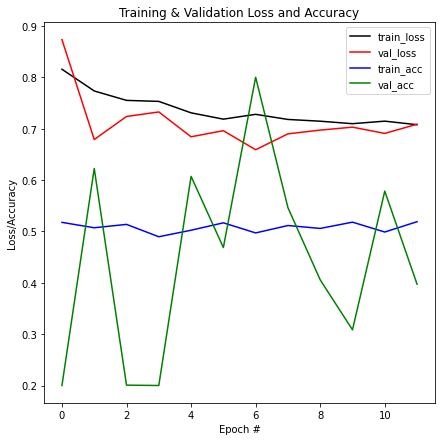

In [43]:
my_model_3.load_weights(weight_path_3)
pred_Y_3 = my_model_3.predict(valX, verbose = True)
plot_history(history_3)

The model more stable. Let's measured through the F1 score.

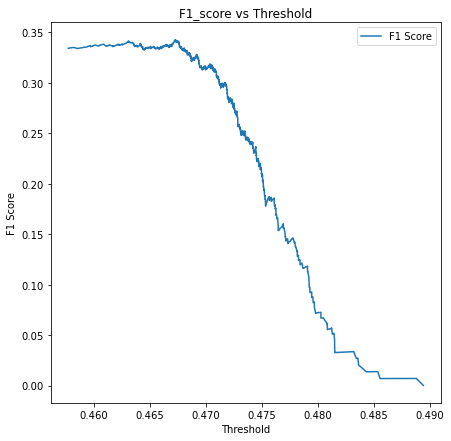

In [49]:
f1_plot(valY, pred_Y_3)

F1 score less around 0.35 which is accepted

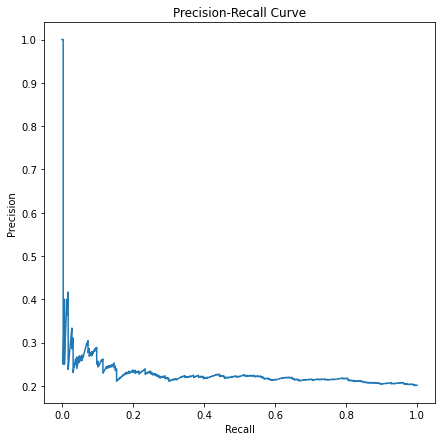

In [54]:
prec_recall_plot(valY, pred_Y_3)

The model looks stable and it perfroms better.

In [55]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
precision, recall, thresholds = precision_recall_curve(valY, pred_Y_3)
best_threshold = best_threshold(precision,recall)
f1_score = calc_f1(precision,recall)
print('f1_score @ best threshold: %.3f'%f1_score[np.nanargmax(f1_score)])

Threshold that maximized f1_score is: 0.467
Corresponding Precision is: 0.218
Recall is: 0.80
f1_score @ best threshold: 0.343


Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

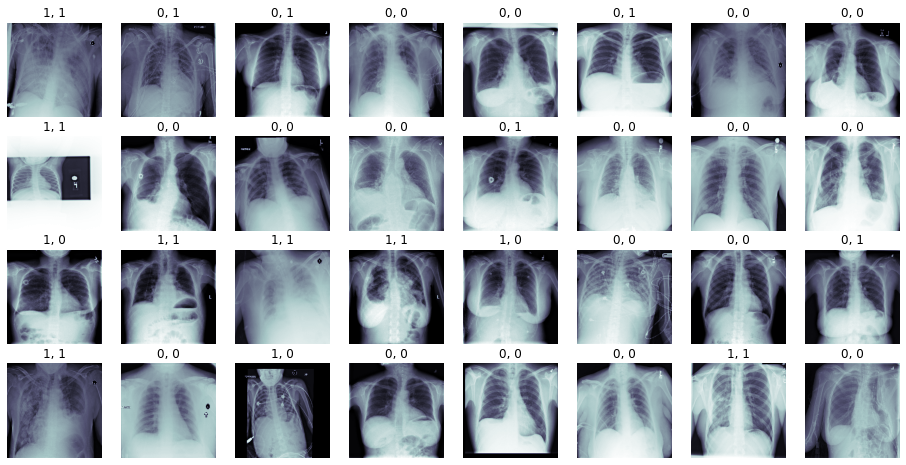

In [72]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo


fig, m_axs = plt.subplots(4, 8, figsize = (16, 8))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:32], valY[0:32], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y_3[i] > best_threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y_3[i] < best_threshold:
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [73]:
## Just save model architecture to a .json:

model_json = my_model_3.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)